# Select suitable MDL test

# Purpose
Find suitable roll decay tests from MDL, to reproduce in Motions later on.

# Methodology
Look at the results from the KLVCC2 ship.
* Load model tests from MDL
* Determine damping
* Predict with
    * SI
    * Ikeda

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from bqplot import pyplot as plt2
import ipywidgets as widgets
#plt.style.use('paper')

#import data
import copy

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
from mdldb.run import Run


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
from mdldb.hdf5_file import Hdf5File
from rolldecayestimators.direct_estimator_cubic import EstimatorCubic,EstimatorQuadraticB

In [3]:
db = database.get_db()

In [4]:
sql = """
SELECT * from run
WHERE model_number='M5057-01-A' and test_type='roll decay' and project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine, index_col='id')

df_rolldecays['ship_speed'].fillna(0, inplace=True)


In [5]:
df_rolldecays

,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_ascii_temp,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,Körfallstyp
id,,,,,,,,,,,,,,,,,,,,
21337,40178362,1,94,1,M5057-01-A,M5057-01-A,166,94.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21338,40178362,1,95,1,M5057-01-A,M5057-01-A,166,95.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-03,roll decay,MDL,None,None,None
21339,40178362,1,96,1,M5057-01-A,M5057-01-A,166,96.0,0.0,"Roll decay, 0 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-11-28,roll decay,MDL,None,None,None
21340,40178362,1,97,1,M5057-01-A,M5057-01-A,166,97.0,15.5,"Roll decay, 15.5 kn",NaN,None,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,\\sspa.local\gbg\LABmeasuredataMDL\40178362\00...,2018-04-04,roll decay,MDL,None,None,None


c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


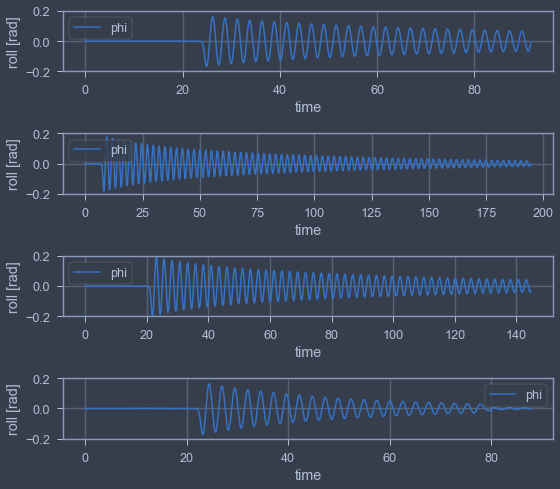

In [6]:
fig,axes=plt.subplots(nrows=len(df_rolldecays))

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.df.plot(y='phi', ax=ax)
    ax.set_ylabel(f"roll [{run.units['phi']}]")
    ax.grid(True)
    ax.set_ylim([-0.2,0.2])
    
plt.tight_layout()

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units
c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


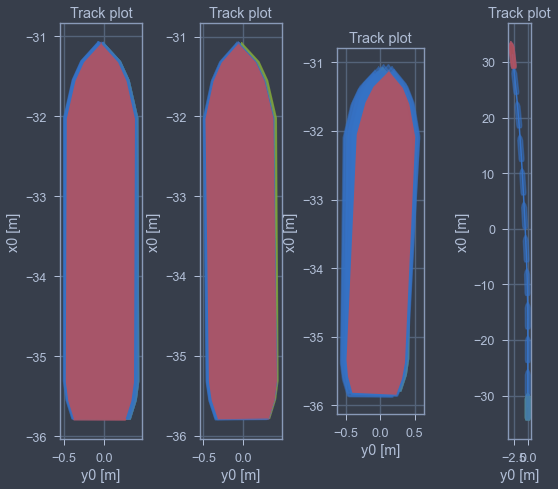

In [7]:
fig,axes=plt.subplots(ncols=len(df_rolldecays))

for (id, row),ax in zip(df_rolldecays.iterrows(),axes):

    run = db.session.query(Run).get(int(id))
    run = database.load_run(run, save_as_example=False, prefer_hdf5=True)
    
    run.track_plot(ax)
    
plt.tight_layout()

## Analyze the damping

In [146]:
run = db.session.query(Run).get(21338)
#run = db.session.query(Run).get(21340)
	
run = database.load_run(run, save_as_example=False, prefer_hdf5=True)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [147]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.9999)
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(1), phi1d_start_tolerance=0.015)
offset_transformer = OffsetTransformer()

In [148]:
#steps = [
##    ('filter',lowpass_filter),
#    ('cutter', cutter), 
##    ('offset_transformer',offset_transformer),
#]
#
#df = run.df.copy()
#df['phi1d']=np.gradient(df['phi'],df.index)
#df['phi2d']=np.gradient(df['phi1d'],df.index)
#
#
#preprosessor = Pipeline(steps=steps)
#preprosessor.fit(X=df[['phi']])
#X = preprosessor.transform(df[['phi','phi1d','phi2d']])
#X-=X['phi'].mean()

steps = [
    ('filter',lowpass_filter),
    ('cutter', cutter), 
#    ('offset_transformer',offset_transformer),
]

df = run.df.copy()

preprosessor = Pipeline(steps=steps)
preprosessor.fit(X=df[['phi']])
X = preprosessor.transform(df[['phi']])
X-=X['phi'].mean()


<AxesSubplot:xlabel='time'>

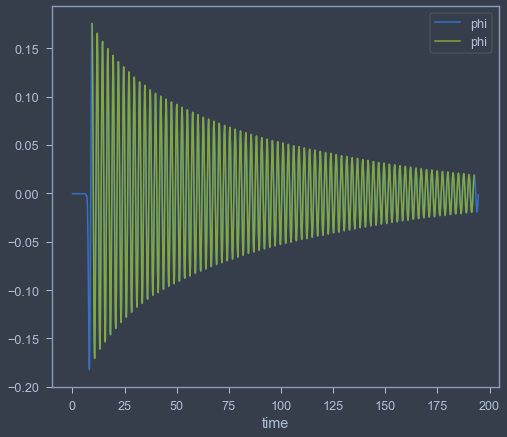

In [149]:
fig,ax=plt.subplots()
run.df.plot(y='phi', ax=ax)
X.plot(y='phi', ax=ax)

In [150]:
estimator_quadratic_b = EstimatorQuadraticB(fit_method='derivation')

In [151]:
estimator_quadratic_b.fit(X=X)
estimator_quadratic_b.score(X=X)

0.9606922613804928

In [152]:
estimator_cubic = EstimatorCubic(fit_method='derivation', maxfev=1000, ftol=1e-15)
estimator_cubic.fit(X=X)
estimator_cubic.score(X=X)

0.9953368120082992

In [153]:
estimator_quadratic_b

EstimatorQuadraticB(B_1A:0.015, B_2A:0.065, C_1A:6.106,)

In [154]:
estimator_cubic

EstimatorCubic(B_1A:0.021, B_2A:0.007, B_3A:0.124, C_1A:6.070, C_3A:3.762, C_5A:-10.619,)

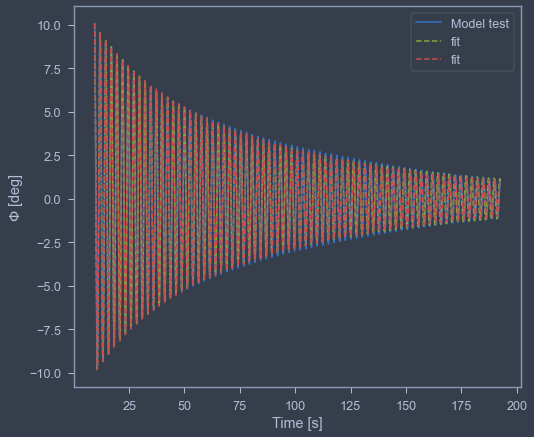

In [155]:
fig,ax=plt.subplots()
estimator_quadratic_b.plot_fit(ax=ax)
estimator_cubic.plot_fit(ax=ax, model_test=False)

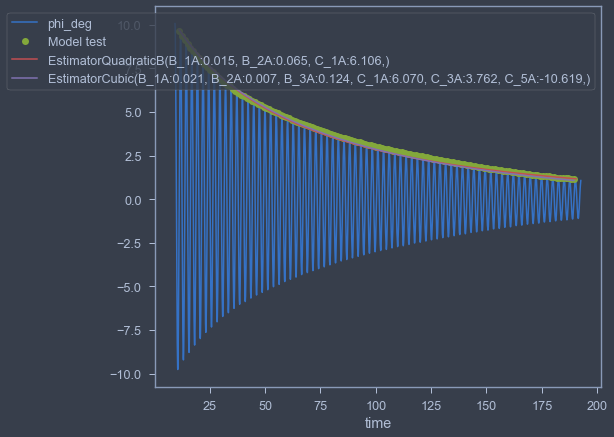

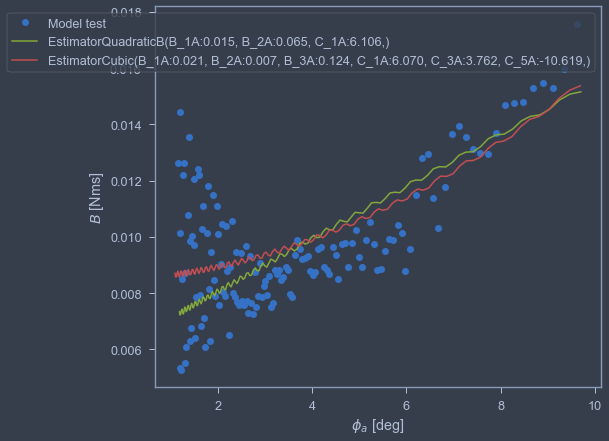

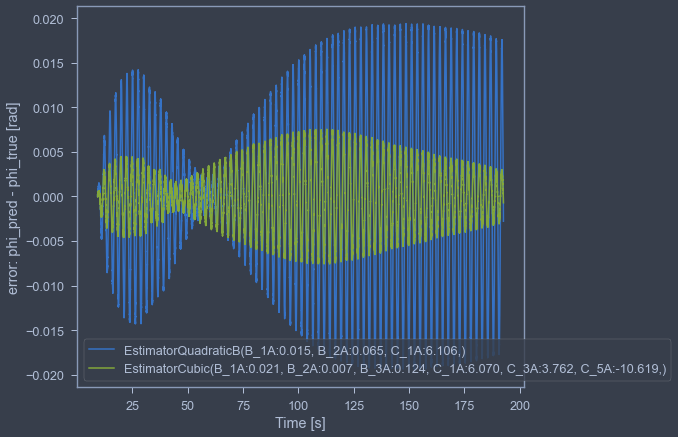

In [156]:
estimator_quadratic_b.calculate_amplitudes_and_damping()
estimator_cubic.calculate_amplitudes_and_damping()

fig,ax=plt.subplots()
X['phi_deg']=np.rad2deg(X['phi'])
X.plot(y='phi_deg', ax=ax)
estimator_quadratic_b.plot_amplitude(ax=ax)
estimator_cubic.plot_amplitude(ax=ax, include_model_test=False)

fig,ax=plt.subplots()
estimator_quadratic_b.plot_damping(ax=ax)
estimator_cubic.plot_damping(ax=ax, include_model_test=False)

fig,ax=plt.subplots()
estimator_quadratic_b.plot_error(ax=ax)
estimator_cubic.plot_error(ax=ax)

<AxesSubplot:>

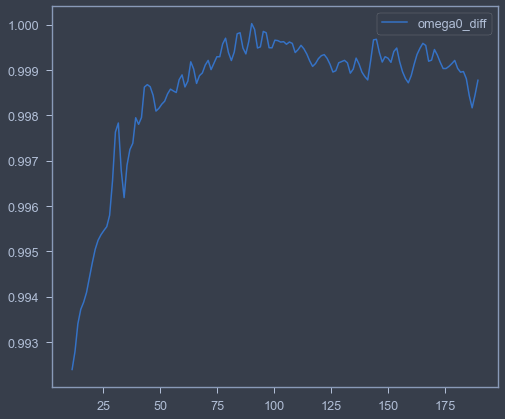

In [157]:
fig,ax=plt.subplots()
X_amplitudes = estimator_quadratic_b.X_amplitudes.copy()
X_amplitudes['omega0_model'] = estimator_quadratic_b.omega0
X_amplitudes['omega0_diff'] = X_amplitudes['omega0_model']/X_amplitudes['omega0']
X_amplitudes.plot(y=['omega0_diff'], ax=ax)

## Investigating the saw-signal...

<AxesSubplot:xlabel='phi'>

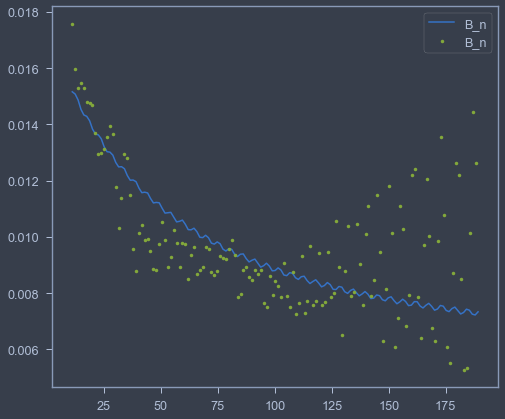

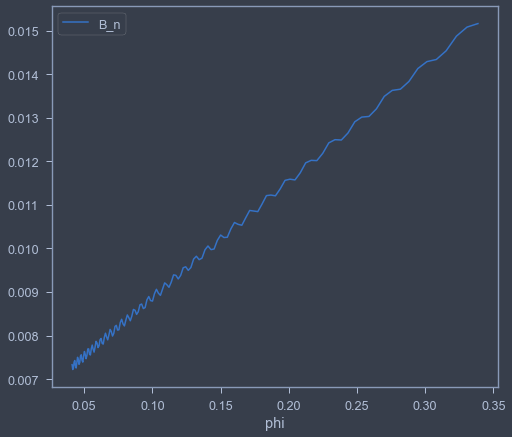

In [158]:
from rolldecayestimators import measure

#X_pred = estimator_quadratic_b.predict(X=X)
t = np.linspace(X.index[0],X.index[-1],1*len(X))
X_pred =estimator_quadratic_b.simulate(t=t, phi0=X.iloc[0]['phi'], phi1d0=X.iloc[0]['phi1d'])

X_amplitudes_pred = measure.calculate_amplitudes_and_damping(X=X_pred)
X_amplitudes_ = measure.calculate_amplitudes_and_damping(X=X)

fig,ax=plt.subplots()
X_amplitudes_pred.plot(y='B_n',style='-', ax=ax)
X_amplitudes_.plot(y='B_n',style='.', ax=ax)
#ax.set_xlim([50,55])

fig,ax=plt.subplots()
X_amplitudes_pred.plot(x='phi',y='B_n',style='-', ax=ax)

In [159]:
key = 'phi1d'
phi1d = np.array(X[key])

index = np.arange(0, len(X.index))
index_later = np.roll(index, shift=-1)
index_later[-1] = index[-1]
mask = (
        ((phi1d[index] > 0) &
         (phi1d[index_later] < 0)) |
        ((phi1d[index] < 0) &
         (phi1d[index_later] > 0))
)

index_first = index[mask]
index_second = index[mask]+1

# y = m + k*x
# k = (y2-y1)/(x2-x1)
# m = y1 - k*x1
# y = 0 --> x = -m/k
X_1 = X.iloc[index_first].copy()
X_2 = X.iloc[index_second].copy()
rows,cols = X_1.shape

x1 = np.array(X_1.index)
x2 = np.array(X_2.index)
y1 = np.array(X_1['phi1d'])
y2 = np.array(X_2['phi1d'])
k = (y2-y1)/(x2-x1)
m = y1 - k*x1
x = -m/k

X_1 = np.array(X_1)
X_2 = np.array(X_2)

factor = (x-x1)/(x2-x1)
factor = np.tile(factor,[cols,1]).T
X_zero = X_1 + (X_2-X_1)*factor

X_zerocrossings = pd.DataFrame(data=X_zero, columns=X.columns, index=x)

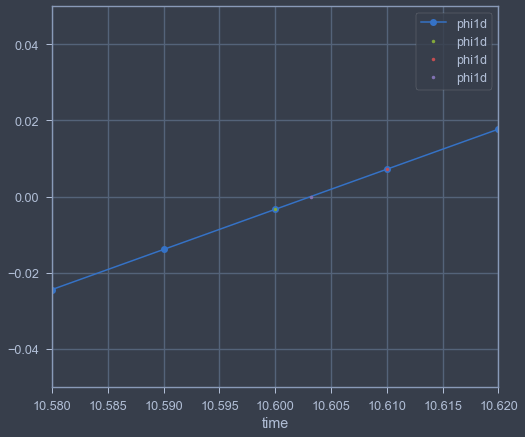

In [160]:
fig,ax=plt.subplots()
X.plot(y='phi1d', ax=ax, style='o-')
X.iloc[index_first].plot(y='phi1d', style='g.', ax=ax)
X.iloc[index_second].plot(y='phi1d', style='r.', ax=ax)


X_zerocrossings.plot(y='phi1d', style='m.',ax=ax)
ax.set_xlim(10.58,10.62)
ax.set_ylim(-0.05,0.05)
ax.grid(True)

In [161]:
X_zerocrossings.head()

,phi,phi_filtered,phi1d,phi2d,phi_deg
10.603184,-0.170470,-0.170220,1.141882e-15,1.054195,-9.767216
11.868862,0.165593,0.165427,1.727785e-15,-1.018164,9.487784
13.134809,-0.160871,-0.161023,1.740795e-15,0.991184,-9.217216
14.402517,0.157128,0.157054,1.542169e-15,-0.964722,9.002784
15.669551,-0.153362,-0.153144,-8.673617e-17,0.942226,-8.786994


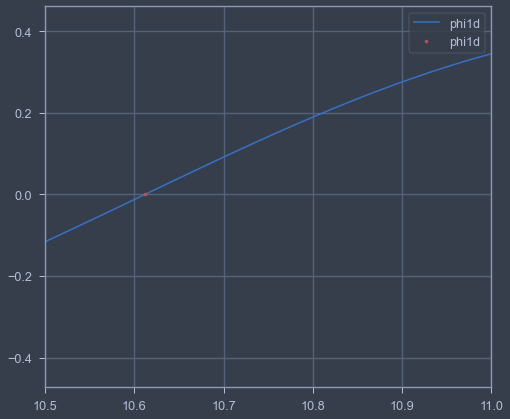

In [162]:
fig,ax=plt.subplots()
X_zerocrossings = measure.get_peaks(X=X_pred)
X_pred.plot(y='phi1d', ax=ax)
X_zerocrossings.plot(y='phi1d', style='r.',ax=ax)
ax.set_xlim(10.5,11)
ax.grid(True)

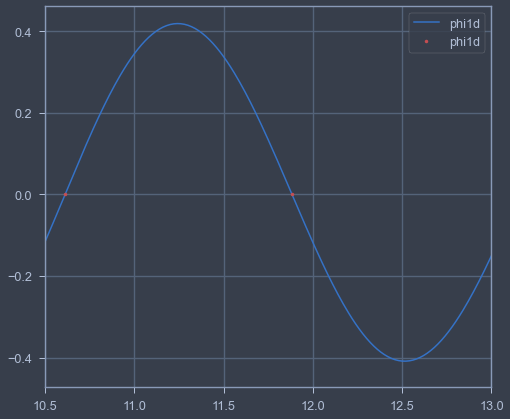

In [163]:
fig,ax=plt.subplots()
X_pred.plot(y='phi1d', ax=ax)
X_zerocrossings.plot(y='phi1d', style='r.',ax=ax)
ax.set_xlim(10.5,13)
ax.grid(True)

In [164]:
X_zerocrossings.head()

,phi,phi1d,phi2d
10.611870,-0.171388,9.658073e-16,1.046479
11.882862,0.167318,-3.105155e-16,-1.021626
13.153929,-0.163396,1.790235e-15,0.997679
14.424978,0.159557,1.411198e-15,-0.974238
15.695960,-0.155855,7.311859e-16,0.951638


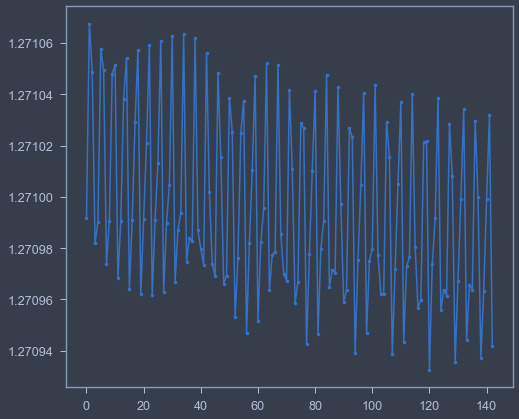

In [165]:
fig,ax=plt.subplots()
ax.plot(np.diff(X_zerocrossings.index),'.-')

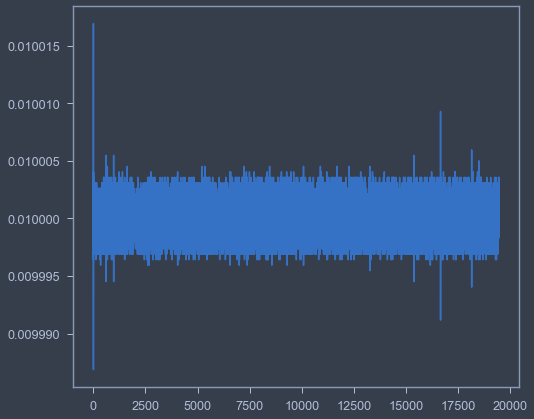

In [166]:
fig,ax=plt.subplots()
ax.plot(np.diff(run.df.index))

In [143]:
size = 100
np.random.seed(0)
x_data = np.arange(size)
y_data = np.cumsum(np.random.randn(size)  * 100.0)

plt2.figure(title='My First Plot')
plt2.plot(x_data, y_data)
plt2.show()